In [8]:
from model_drift import settings

from model_drift.stats import calc_p_categorical, calc_p_real, calculate_alerts
from model_drift.helpers import prepare_padchest
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [9]:
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from scipy.stats import ks_2samp
from numpy.random import randn
from numpy.random import lognormal

from scipy.special import kolmogi

def calc_critical_value(n1, n2, q=.01):
    if n2 == 0:
        return None
    return kolmogi(q)*np.sqrt((n1+n2)/(n1*n2))

alphas = {
    100: 1.22,
    50: 1.36,
    25: 1.48,
    10: 1.63,
    5: 1.73,
    1: 1.95
}

# Real Valued Number Drift Detection

In [10]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)



In [11]:
from scipy.stats import ks_2samp
def ks_2sample_critical_value(n1, n2, alpha=1):

    alpha_table = {
    100: 1.22,
    50: 1.36,
    25: 1.48,
    10: 1.63,
    5: 1.73,
    1: 1.95
    }

    n1 = min(10000, n1)
    n2 = min(10000, n2)
    if n2 == 0:
        return None
    ca = alpha_table[alpha]
    return ca * np.sqrt((n1 + n2) / (n1 * n2))

def ks_2sample_test(train, test):
    if len(test):
        return ks_2samp(train, test, mode='asymp')
    return None, None


class DriftCalculator(object):

    def __init__(self, ref, real_cols=None, cat_cols=None, alphas=(100, 50, 25, 5, 1)):

        self.ref = ref
        self.real_cols =  real_cols or []
        self.cat_cols = cat_cols or []
        self.alphas = alphas

    @property
    def real_agg_funcs(self):
        return {col: lambda tar: self.real_value_func(self.ref[col], tar) for col in self.real_cols}

    def real_value_func(self, ref, target):
        ks, p = ks_2sample_test(ref, target)
        out = {"mean": np.mean(target), "pvalue": p, "dist": ks, "nobs": len(target)}
        for a in self.alphas:
            out[(a, 'crit')] = ks_2sample_critical_value(len(ref), len(target), alpha=a)
            out[(a, 'drift')] = out["dist"] - out[(a, 'crit')]
        return pd.Series(out)


def rolling_dt_apply_with_stride(
    dataframe,
    function,
    window="30D",
    stride="D",
    unique_only=False,
    center=False,
    min_periods=None,
) -> pd.DataFrame:
    if unique_only:
        tmp_index = dataframe.index.unique()
    else:
        tmp_index = pd.date_range(
            dataframe.index.min(), dataframe.index.max(), freq=stride
        )
    try:
        delta = pd.tseries.frequencies.to_offset(window)
        fdelta = (delta / 2) if center else pd.tseries.frequencies.to_offset(window) * 0
        bdelta = delta - fdelta
    except TypeError as e:
        raise ValueError("Centering does not work with all windows and strides") from e

    def _apply(i):
        window = dataframe[i - bdelta : i + fdelta]
        if min_periods is not None and len(window) < min_periods:
            return None
        return window.agg(function)

    return pd.concat({i: _apply(i) for i in tmp_index}, axis=0).unstack()


In [12]:
# Add an "age" and "image size column"``
df['age'] = (df["StudyDate"]-df['PatientBirth']) / np.timedelta64(1, 'Y')
df['image_size'] = df['Rows_DICOM']*df['Columns_DICOM']

# Define graph constants
freq = "30d"
resolution = '5d'
col = 'age'
split_date = "2014-01-01"

# Enure that column is a numeric value
df[col] = pd.to_numeric(df[col], errors='coerce')

# Set index and split dataframe
df = df.set_index('StudyDate', drop=False).sort_index()
df_ref = df.loc[(df.index < split_date)]
df_target = df[(df.index >= split_date)]



In [13]:
drifter = DriftCalculator(df_ref, real_cols=['age'])
dft = rolling_dt_apply_with_stride(df_target, drifter.real_agg_funcs)

In [14]:
dft

age                                              \
                 mean        pvalue      dist    nobs (100, crit)   
2014-01-01  72.334590  2.602467e-01  0.533285     3.0    0.704473   
2014-01-02  71.170524  2.395211e-02  0.410991    12.0    0.352395   
2014-01-03  69.741985  9.001280e-03  0.364705    19.0    0.280153   
2014-01-04  69.741985  9.001280e-03  0.364705    19.0    0.280153   
2014-01-05  69.741985  9.001280e-03  0.364705    19.0    0.280153   
...               ...           ...       ...     ...         ...   
2017-11-13  59.636904  4.772564e-06  0.079568  1026.0    0.039994   
2017-11-14  59.678920  2.145972e-06  0.080771  1058.0    0.039442   
2017-11-15  59.602022  3.520240e-06  0.077764  1101.0    0.038739   
2017-11-16  59.591596  2.061819e-06  0.079795  1087.0    0.038963   
2017-11-17  59.778257  7.924441e-07  0.083253  1068.0    0.039274   

                                                                       \
           (100, drift) (50, crit) (50, drift) (25, crit) (25, drift)   
2014-01-01    -0.171188   0.785314   -0.252029   0.854607   -0.321321   
2014-01-02     0.058596   0.392834    0.018158   0.427495   -0.016504   
2014-01-03     0.084553   0.312302    0.052404   0.339858    0.024848   
2014-01-04     0.084553   0.312302    0.052404   0.339858    0.024848   
2014-01-05     0.084553   0.312302    0.052404   0.339858    0.024848   
...                 ...        ...         ...        ...         ...   
2017-11-13     0.039574   0.044584    0.034984   0.048517    0.031050   
2017-11-14     0.041329   0.043968    0.036803   0.047847    0.032923   
2017-11-15     0.039025   0.043184    0.034580   0.046995    0.030770   
2017-11-16     0.040832   0.043434    0.036361   0.047267    0.032529   
2017-11-17     0.043979   0.043781    0.039472   0.047644    0.035609   

                                                      
           (5, crit) (5, drift) (1, crit) (1, drift)  
2014-01-01  0.998966  -0.465680  1.126002  -0.592717  
2014-01-02  0.499708  -0.088716  0.563254  -0.152263  
2014-01-03  0.397266  -0.032561  0.447785  -0.083080  
2014-01-04  0.397266  -0.032561  0.447785  -0.083080  
2014-01-05  0.397266  -0.032561  0.447785  -0.083080  
...              ...        ...       ...        ...  
2017-11-13  0.056713   0.022855  0.063925   0.015643  
2017-11-14  0.055930   0.024841  0.063042   0.017729  
2017-11-15  0.054933   0.022831  0.061919   0.015846  
2017-11-16  0.055251   0.024545  0.062277   0.017518  
2017-11-17  0.055692   0.027561  0.062775   0.020478  

[1417 rows x 14 columns]

In [18]:


# Calculate stats on refernce points
m = df_ref[col].mean()
std = df_ref[col].std()
nobs = len(df_ref)

# Calculate rolling stats on target points
df_roll = df_target.rolling(freq)[col].mean().resample('1d').mean()

df_roll.index = map(lambda x: x.date(), df_roll.index.to_list())
# Find outliers in the target data


# Define overlay area
dfmean = pd.DataFrame([(df_roll.index.min(), m), (df_roll.index.max(), m)], columns=[
                      'StudyDate', col]).set_index("StudyDate")
dfstd = pd.DataFrame([(df_roll.index.min(), std/3, -std/3), (df_roll.index.max(),
                     std/3, -std/3), ], columns=['StudyDate', 'H', 'L']).set_index("StudyDate")


# Calculate mean rolling pvalue with stats calcuated at some resolution
df_roll_p = df_target[col].resample(resolution).apply(
    lambda x: calc_p_real(df_ref[col], x))
df_roll_crit = df_target[col].resample(resolution).apply(
    lambda x: calc_critical_value(len(df_ref), len(x), q=0.005))


is_drift = (df_roll_p-df_roll_crit)
is_drift.index = map(lambda x: x.date(), is_drift.index.to_list())


In [19]:
for x in tmp.resample().rolling('30D'):
    print(x.index.min(), x.index.max(), f"range: {x.index.max()-x.index.min()}")

NameError: name 'tmp' is not defined

In [20]:



N = 1000
start_date = pd.to_datetime("2010-1-1")
end_date = pd.tseries.offsets.Day(N) + start_date
R = 25
tmp_df = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='D'))

dataframe = pd.concat([tmp_df.sample(N//R) for _ in range(R)]).sort_index()
dataframe['value'] = 1
dataframe['value2'] = 2


# print(dataframe)

# # # rolling_dt_apply_with_stride(df2, functions=[np.mean])

# # window = '30d'
# # stride = 'D'
# # delta = pd.tseries.frequencies.to_offset(stride)
# # tmp_index = pd.date_range(dataframe.index.min()+delta, dataframe.index.max(), freq=stride)

def my_func(values: pd.Series) -> pd.Series:
    return pd.Series({"mean": np.mean(values), "nobs": len(values)})


d = rolling_dt_apply_with_stride(dataframe, {"value": my_func, "value2": my_func}, stride='W', min_periods=12)

d

value       value2      
            mean  nobs   mean  nobs
2010-01-17   1.0  16.0    2.0  16.0
2010-01-24   1.0  26.0    2.0  26.0
2010-01-31   1.0  30.0    2.0  30.0
2010-02-07   1.0  34.0    2.0  34.0
2010-02-14   1.0  33.0    2.0  33.0
...          ...   ...    ...   ...
2012-08-26   1.0  33.0    2.0  33.0
2012-09-02   1.0  34.0    2.0  34.0
2012-09-09   1.0  40.0    2.0  40.0
2012-09-16   1.0  35.0    2.0  35.0
2012-09-23   1.0  36.0    2.0  36.0

[141 rows x 4 columns]

In [1]:
pd.period_range(start=dataframe.index.min(), end=dataframe.index.max(), freq='W')

NameError: name 'pd' is not defined

In [22]:
center = True

window = 'M'
stride = '1D'

try:
    delta = pd.tseries.frequencies.to_offset(window)
    fdelta = (delta/2) if center else pd.tseries.frequencies.to_offset(window)*0
    bdelta = (delta-fdelta)
except TypeError as e:
    raise ValueError("Centering does not work with all windows and strides") from e
    
tmp_index = pd.date_range(dataframe.index.min(), dataframe.index.max(), freq=stride)

i = 40
dataframe[tmp_index[i]-bdelta:tmp_index[i]+fdelta]

ValueError: Centering does not work with all windows and strides

In [23]:
f = pd.to_timedelta('13d')//2 + pd.to_timedelta(0)

f

Timedelta('6 days 12:00:00')

In [24]:
tmp_df["2010-01-01":"2010-01-31"]

""
2010-01-01
2010-01-02
2010-01-03
2010-01-04
2010-01-05
2010-01-06
2010-01-07
2010-01-08
2010-01-09
2010-01-10


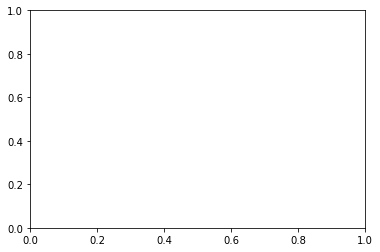

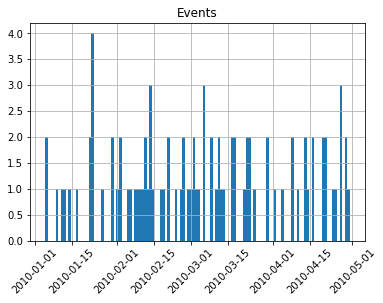

TypeError: rolling() got an unexpected keyword argument 'step'

In [25]:
import pandas as pd
import numpy as np
from collections import defaultdict


fig, ax = plt.subplots(1,1)
## Building a dataframe
start_date = "2010-1-1"
end_date = "2010-04-30"
N = 90
R = 5
tmp_idx = pd.date_range(start_date, end_date, freq='D')
tmp_df = pd.DataFrame(index=tmp_idx)

df2 = pd.concat([tmp_df.sample(N//R) for i in range(R)]).sort_index()
df2['value'] = 1

fig, ax = plt.subplots()
ax = df2.reset_index()['index'].hist(bins=len(tmp_idx))
ax.set(title='Events')
plt.setp(ax.get_xticklabels (), Rotation=45)
plt.show()

hits = defaultdict(int)
for x in df2.rolling('30D', step='1d'):
    hits[x.index.max()] += 1
    
fig, ax = plt.subplots()
x,y = zip(*hits.items())
plt.bar(x, y)
ax.set(title='Built In Rolling Hits')
plt.setp(ax.get_xticklabels (), Rotation=45)
plt.show()


delta = pd.to_timedelta('30D')
ixes = pd.date_range(df2.index.min(), df2.index.max(), freq='D').intersection(df2.index)
hits2 = defaultdict(int)
for x in [df2[ix-delta:ix] for ix in ixes]:
    hits2[x.index.max()] += 1

fig, ax = plt.subplots()    
x,y = zip(*hits2.items())
plt.bar(x, y)
ax.set(title='Disired Hits')
plt.setp(ax.get_xticklabels(), Rotation=45)
plt.show()

In [26]:
x = df2.agg([np.mean, np.var])
x.name = '2010-01-01'

x

,value
mean,1.0
var,0.0


In [27]:
pd.IndexSlice("2010-01-01", )

TypeError: '_IndexSlice' object is not callable

In [28]:
tmp = df.iloc[:100000]

window = '30d'
freq = 'D'

delta = pd.to_timedelta(window)
ixes = pd.date_range(tmp.index.min(), tmp.index.max(), freq=freq)

ixes = ixes[ixes-delta >= ixes.min()]
for start, stop in zip(ixes-delta, ixes):
    x = tmp[start:stop]
    if len(x):
        print("start/stop", start, stop, stop-start)
        print(" actual dates", x.index.min(), x.index.max(), x.index.max()-x.index.min())
# ixes

start/stop 2007-05-03 00:00:00 2007-06-02 00:00:00 30 days 00:00:00
 actual dates 2007-05-03 00:00:00 2007-05-31 00:00:00 28 days 00:00:00
start/stop 2007-05-04 00:00:00 2007-06-03 00:00:00 30 days 00:00:00
 actual dates 2007-05-31 00:00:00 2007-05-31 00:00:00 0 days 00:00:00
start/stop 2007-05-05 00:00:00 2007-06-04 00:00:00 30 days 00:00:00
 actual dates 2007-05-31 00:00:00 2007-05-31 00:00:00 0 days 00:00:00
start/stop 2007-05-06 00:00:00 2007-06-05 00:00:00 30 days 00:00:00
 actual dates 2007-05-31 00:00:00 2007-05-31 00:00:00 0 days 00:00:00
start/stop 2007-05-07 00:00:00 2007-06-06 00:00:00 30 days 00:00:00
 actual dates 2007-05-31 00:00:00 2007-05-31 00:00:00 0 days 00:00:00
start/stop 2007-05-08 00:00:00 2007-06-07 00:00:00 30 days 00:00:00
 actual dates 2007-05-31 00:00:00 2007-05-31 00:00:00 0 days 00:00:00
start/stop 2007-05-09 00:00:00 2007-06-08 00:00:00 30 days 00:00:00
 actual dates 2007-05-31 00:00:00 2007-05-31 00:00:00 0 days 00:00:00
start/stop 2007-05-10 00:00:00 20

In [29]:
ixes

DatetimeIndex(['2007-06-02', '2007-06-03', '2007-06-04', '2007-06-05',
               '2007-06-06', '2007-06-07', '2007-06-08', '2007-06-09',
               '2007-06-10', '2007-06-11',
               ...
               '2013-04-14', '2013-04-15', '2013-04-16', '2013-04-17',
               '2013-04-18', '2013-04-19', '2013-04-20', '2013-04-21',
               '2013-04-22', '2013-04-23'],
              dtype='datetime64[ns]', length=2153, freq='D')

In [ ]:
for x in df.iloc[:1000].set_index('StudyDate').resample('1d').apply(lambda x: list(x) if len(x) else None).dropna().rolling('30d', closed='both', min_periods=30):
    print(x.index.max()-x.index.min(), x.index.max(), x.index.min())
    if x.index.max()-x.index.min() == pd.to_timedelta('30d'):
        break
x

In [30]:
import tqdm
# def calc_critical_value(n1, n2, alpha=100):
#     n1 = min(10000, n1)
#     n2 = min(10000, n2)
#     if n2 == 0:
#         return None
#     ca = alphas[alpha]
#     return ca * np.sqrt((n1 + n2) / (n1 * n2))

alphas = {
    100: 1.22,
    50: 1.36,
    25: 1.48,
    10: 1.63,
    5: 1.73,
    1: 1.95
}

def calc_p_real2(train, test):
    if len(test):
        return ks_2samp(train, test, mode='asymp')
    return None, None

dfx = df_target[col].resample("1d").apply(list)
N = 90
new_df = []
save = []
for i in tqdm.tqdm_notebook(range(N, len(dfx)), total=len(dfx)-N):
    x = sum(dfx.iloc[i: i + N].values, [])
    ks, p = calc_p_real2(df_ref[col], x)
    d =  {"StudyDate": dfx.index.values[i], "mean": np.mean(x), "p": p, "stat": ks,}
    for a in alphas.keys():
        d[f'crit_{a}'] = calc_critical_value(len(df_ref), len(x),  q=a/1000)
    if  d['stat']-d['crit_1'] < 0:
        save.append(x)
    new_df.append(d)
new_df = pd.DataFrame(new_df).set_index('StudyDate')
new_df.index = map(lambda x: x.date(), new_df.index.to_list())


  0%|          | 0/1327 [00:00<?, ?it/s]

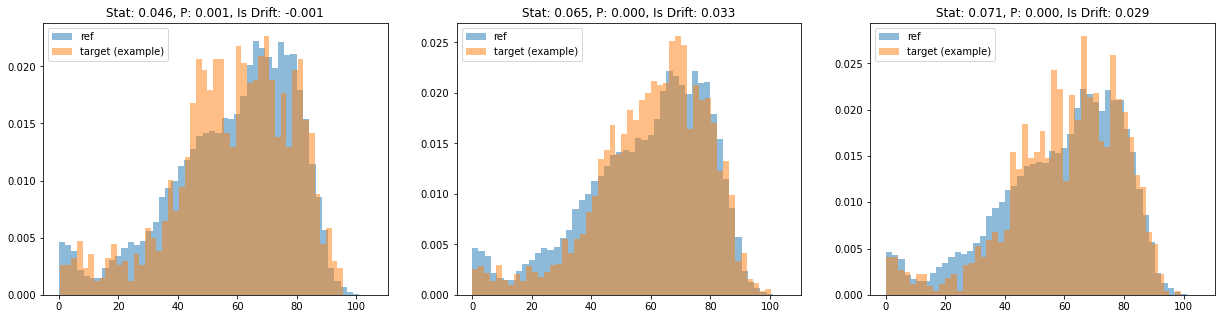

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7*3, 5))

i = 438-90
target = sum(dfx.iloc[i: i + N].values, [])
target = save[10]

stat, p = ks_2samp(df_ref[col], target)
crit = calc_critical_value(len(df_ref), len(target), q=0.001)

is_drift_ = stat-crit

ax1.set_title(f"Stat: {stat:.3f}, P: {p:.3f}, Is Drift: {is_drift_:.3f}")
ax1.hist(df_ref[col], alpha=0.5, label='ref', density=True, bins=50)
ax1.hist(target, alpha=.5, label='target (example)', density=True, bins=50)
ax1.legend()


i = 438-90
target = sum(dfx.iloc[i: i + N].values, [])
stat, p = ks_2samp(df_ref[col], target)
crit = calc_critical_value(len(df_ref), len(target), q=0.001)

is_drift_ = stat-crit
ax2.set_title(f"Stat: {stat:.3f}, P: {p:.3f}, Is Drift: {is_drift_:.3f}")
ax2.hist(df_ref[col], alpha=0.5, label='ref', density=True, bins=50)
ax2.hist(target, alpha=.5, label='target (example)', density=True, bins=50)
ax2.legend()


i = 0
target = sum(dfx.iloc[i: i + N].values, [])
stat, p = ks_2samp(df_ref[col], target)
crit = calc_critical_value(len(df_ref), len(target), q=0.001)

is_drift_ = stat-crit
ax3.set_title(f"Stat: {stat:.3f}, P: {p:.3f}, Is Drift: {is_drift_:.3f}")
ax3.hist(df_ref[col], alpha=0.5, label='ref', density=True, bins=50)
ax3.hist(target, alpha=.5, label='target (example)', density=True, bins=50)
ax3.legend()

## Plot Real Valued Graph

In [33]:
dfmean = pd.DataFrame([(dfx.index.min(), m), (dfx.index.max(), m)], columns=[
                      'StudyDate', col]).set_index("StudyDate")
dfstd = pd.DataFrame([(dfx.index.min(), std/3, -std/3), (dfx.index.max(),
                     std/3, -std/3), ], columns=['StudyDate', 'H', 'L']).set_index("StudyDate")

alerts = []
alerts += calculate_alerts(new_df['mean'], new_df['mean'] < (m - std/3))
alerts += calculate_alerts(new_df['mean'], new_df['mean'] > (m + std/3))

In [35]:
new_df

,mean,p,stat,crit_100,crit_50,crit_25,crit_10,crit_5,crit_1,is_drift
2014-04-01,62.457538,1.634748e-42,0.087214,0.015350,0.017034,0.018566,0.020415,0.021709,0.024452,0.062762
2014-04-02,62.502157,1.156147e-43,0.088024,0.015286,0.016963,0.018488,0.020330,0.021618,0.024350,0.063674
2014-04-03,62.455027,1.438179e-43,0.087662,0.015240,0.016911,0.018432,0.020268,0.021553,0.024276,0.063386
2014-04-04,62.468018,4.107447e-44,0.087988,0.015201,0.016868,0.018385,0.020216,0.021498,0.024214,0.063774
2014-04-05,62.484438,1.508019e-44,0.088032,0.015134,0.016794,0.018304,0.020127,0.021403,0.024107,0.063926
...,...,...,...,...,...,...,...,...,...,...
2017-11-13,58.543679,1.773187e-02,0.111724,0.089810,0.099662,0.108623,0.119441,0.127013,0.143059,-0.031335
2017-11-14,57.529693,1.902667e-02,0.133398,0.108235,0.120107,0.130907,0.143944,0.153070,0.172408,-0.039010
2017-11-15,56.364236,1.293411e-02,0.160026,0.124961,0.138669,0.151137,0.166189,0.176725,0.199051,-0.039025
2017-11-16,55.272402,1.777731e-02,0.207368,0.168148,0.186593,0.203369,0.223623,0.237801,0.267843,-0.060475


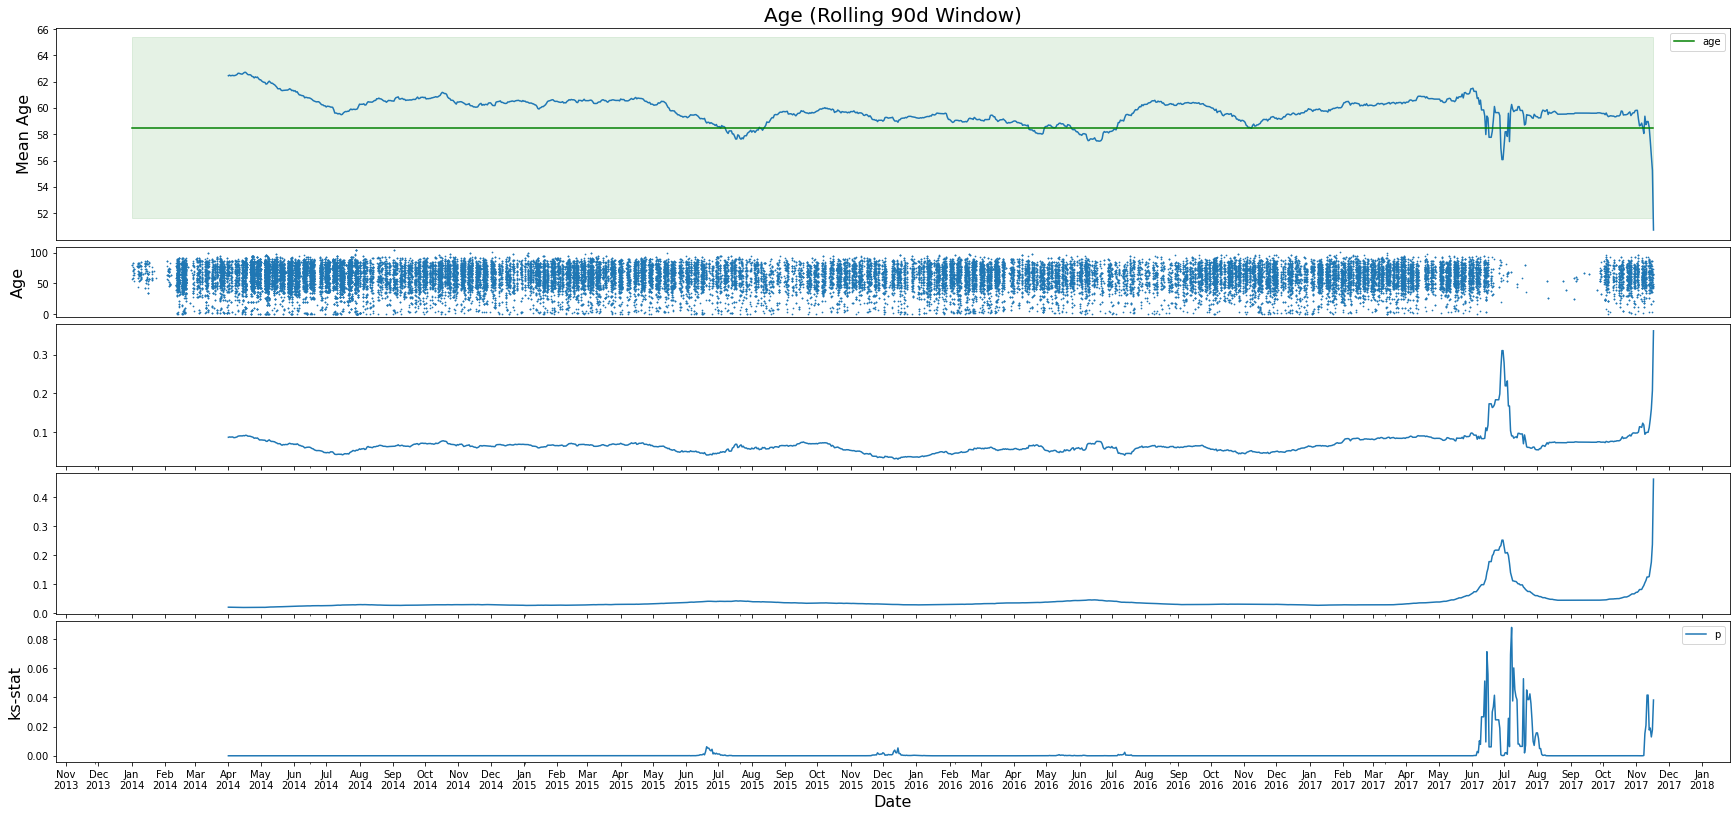

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(
    30, 15), sharex=True, gridspec_kw={'height_ratios': [15, 5, 10, 10, 10], 'wspace':0, 'hspace':.05})


new_df['mean'].plot(ax=axes[0], label='Age')
dfmean.plot(ax=axes[0], color='green')
axes[0].fill_between(dfstd.index, m+dfstd['H'], m +
                     dfstd['L'], 3, color='green', alpha=.1)
for dfalert in alerts:
    _ = axes[0].fill_between(dfalert.index, dfalert['h'],
                             dfalert['l'], 3, color='red', alpha=.25)

axes[1].scatter(df_target.index.tolist(), df_target[col], marker='.', s=2)


alpha = 1
new_df['is_drift'] = new_df['stat']-new_df[f'crit_{alpha}']

# df_roll_p.plot(ax=axes[-1], label="ks-stat")
# df_roll_crit.plot(ax=axes[-1], label='critical')
new_df['stat'].plot(ax=axes[2])
new_df['crit_5'].plot(ax=axes[3])
new_df['p'].plot(ax=axes[4])
# df_roll_p2.plot(ax=axes[-1], label=calc_p_real2.name)
# df_roll_t.plot(ax=axes[-1], label="t")

# axes[-1].plot([new_df.index.min(), new_df.index.max()], [0, 0], 'r', alpha=.5)
# axes[-1].fill_between([new_df.index.min(), new_df.index.max()], [new_df['is_drift'].min()*1.1, new_df['is_drift'].min()*1.1], [0, 0], 3, color='green', alpha=.1)
# axes[-1].fill_between([new_df.index.min(), new_df.index.max()], [0, 0], [new_df['is_drift'].max()*1.1, new_df['is_drift'].max()*1.1], 3, color='red', alpha=.1)

# from datetime import timedelta

# axes[-1].plot([new_df.index.min(), new_df.index.min()], [new_df['is_drift'].max()*0.5, new_df['is_drift'].min()*0.5], ':k', alpha=1, linewidth=3)
# axes[-1].plot([new_df.index.min()+timedelta(days=N), new_df.index.min()+timedelta(days=N)], [new_df['is_drift'].max()*.5, new_df['is_drift'].min()*.5], ':k', alpha=1, linewidth=3)


# Format Titles and ticks
verbose_column_nane = col.replace('_', ' ').title()
axes[0].set_title(
    f"{verbose_column_nane} (Rolling {N}d Window)", fontsize=20)
axes[0].set_ylabel(f'Mean {verbose_column_nane}', fontsize=16)
axes[1].set_ylabel(f'{verbose_column_nane}', fontsize=16)

# axes[0].get_legend().remove()

axes[0].axes.get_xaxis().set_visible(False)
axes[1].axes.get_xaxis().set_visible(False)

axes[-1].set_xlabel('Date', fontsize=16)
axes[-1].set_ylabel("ks-stat", fontsize=16)
# axes[-1].set_ylim([-1, 1])
axes[-1].legend()

# Create custom ticks using matplotlib date tick locator and formatter
loc = mdates.MonthLocator(interval=1)
axes[-1].xaxis.set_major_locator(loc)
fmt = mdates.DateFormatter('%b\n%Y')
axes[-1].xaxis.set_major_formatter(fmt)
plt.xticks(rotation=0, fontsize=10)
_ = plt.yticks(fontsize=10)


# Categorical Drift Analysis

In [ ]:
new_df.reset_index()[new_df.reset_index()['is_drift']<0]

In [ ]:
new_df.index.min()

In [ ]:
dfx.apply(len).describe()

In [ ]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)

view_dict = {"Frontal": ["POSTEROANTERIOR", "ANTEROPOSTERIOR", "PA", "AP"], "Lateral": ["LL", "LATERAL", "RL", "LLD"]}
view_dict_rev = {vv: k for k,v in view_dict.items() for vv in v}
df['view'] = df['ViewPosition_DICOM'].apply(lambda x: view_dict_rev.get(x, 'Other'))

df = df.set_index('StudyDate', drop=False).sort_index()

In [ ]:
# Define graph constants
col = "Manufacturer_DICOM"
# col = "view"
freq = "30D"
resolution = '30d'
split_date = "2014-01-01"

# Encode column into numeric values
colc = col+'_codes'
df[col] = df[col].astype('category')
df[colc] = df[col].cat.codes

# Set index and split dataframe
df_ref = df.loc[(df.index < split_date)]
df_target = df[(df.index >= split_date)]

train_range = df_ref.index.min(), df_ref.index.max()
test_range = df_target.index.min(), df_target.index.max()

# Calculate Rolling statisics on target data
dfp = df_target[col].resample(resolution).apply(lambda s: s.value_counts(
    normalize=True).sort_index()).unstack().fillna(0).rolling(freq).mean()
dfp = dfp.div(dfp.sum(axis=1), axis=0)

# Calculate reference statistics
ref_stats = sorted(df_ref[col].value_counts(
    normalize=True).sort_index().to_dict().items(), key=lambda x: x[0])
(k, v), (_, v2) = zip(*([('StudyDate', df_target.index.min())]+ref_stats)), zip(*([('StudyDate', df_target.index.max())]+ref_stats))
dfmean = pd.DataFrame([v, v2], columns=k).set_index('StudyDate')

# Calculate mean rolling pvalue with stats calcuated at some resolution
df_rollp = df_target[colc].resample(resolution).apply(
    lambda x: calc_p_categorical(df_ref[colc], x)).dropna().rolling(freq).mean()


## Plot Categorical Analysis

In [ ]:
fig, axes_rows = plt.subplots(nrows=2, ncols=2, figsize=(30, 10), gridspec_kw={
                              'width_ratios': [1, 20], 'height_ratios': [5, 3]}, sharey=True)
fig.tight_layout()

axes_rows[1][0].set_visible(False)

# Fix colors
cm = plt.get_cmap("Set1")
my_colors = cm(range(df[col].nunique()))
color_dict = dict(zip(sorted(df[col].unique()), my_colors))
dfp.columns = [str(c) for c in dfp.columns]
for c in color_dict:
    if c not in dfp:
        dfp[c] = 0

dfp = dfp[sorted(color_dict.keys())]
dfmean.columns = dfmean.columns.map(str)
dfmean = dfmean[sorted(color_dict.keys())]


dfmean.plot.area(ax=axes_rows[0][0], color=[color_dict[c]
                 for c in dfmean], alpha=0.7)
dfp.plot.area(ax=axes_rows[0][1], color=[color_dict[c]
              for c in dfp], alpha=0.7)
df_rollp.plot(ax=axes_rows[1][1])

axes_rows[0][1].legend(bbox_to_anchor=(-0.01, -0.2), loc='bottom right')

verbose_column_nane = col.replace('_', ' ').title()
axes_rows[0][1].set_title(
    f"{verbose_column_nane} (Rolling {freq} Window)", fontsize=20)

axes_rows[0][0].get_legend().remove()
axes_rows[0][0].axes.get_xaxis().set_visible(False)
axes_rows[0][1].axes.get_xaxis().set_visible(False)

axes_rows[0][1].set_ylabel(f'{verbose_column_nane}', fontsize=16)

# Create custom ticks using matplotlib date tick locator and formatter
loc = mdates.MonthLocator(interval=1)
axes_rows[-1][-1].xaxis.set_major_locator(loc)
fmt = mdates.DateFormatter('%b\n%Y')
axes_rows[-1][-1].xaxis.set_major_formatter(fmt)
plt.xticks(rotation=0, fontsize=10)
_ = plt.yticks(fontsize=10)


In [ ]:
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from scipy.stats import ks_2samp
from numpy.random import randn
from numpy.random import lognormal

# alphas = {
#     100: 1.22,
#     50: 1.36,
#     25: 1.48,
#     10: 1.63,
#     5: 1.73,
#     1: 1.95
# }

# def calc_critical_value(n1, n2, alpha=100):
#     if n2 == 0:
#         return None
#     ca = alphas[alpha]
#     return ca*np.sqrt((n1+n2)/(n1*n2))


def ks_2samp_test(ref_dist=randn, target_dist=randn, num_samples = 2000, num_trials=100):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ref = randn(num_samples)
    ax1.set_title("(a) Distribution Examples")
    ax1.hist(ref, alpha=0.5, label='ref', bins=50)
    ax1.hist(target_dist(num_samples), alpha=.5, label='target (example)', bins=50)
    ax1.legend()

    crt = calc_critical_value(num_samples, num_samples, q=0.001)
    vals = [ks_2samp(ref, target_dist(num_samples), mode="auto") for _ in range(num_trials)]
    dstat, pvals = zip(*vals)
    is_drift = [d-crt for d in dstat]
    ax2.set_title("(b)")
    ax3.set_title("(c)")
    ax2.plot(pvals, label='pvalue')
    ax2.plot(dstat, label='d-stat')
    ax3.plot(is_drift, label='drift_stat')
    ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')
    ax2.legend()
    ax3.legend()

ks_2samp_test(num_trials=500)
ks_2samp_test(target_dist=lambda n: randn(n)+3)
ks_2samp_test(target_dist=lambda n: randn(n)*1.5)

In [ ]:
import random
from scipy.stats import chisquare, power_divergence

from collections import Counter


def categorical_test(ref_dist: dict, target_dist=None, num_samples=2000, num_trials=100, test='chisquare'):
    
    # testers = {"chisquare": chisquare, "my_test": my_test}

    # test_func = testers[test]
    
    target_dist = target_dist or ref_dist

    ref_dist_func = lambda nsamp: random.choices(
        list(ref_dist.keys()), list(ref_dist.values()), k=nsamp
    )
    target_dist_func = lambda nsamp: random.choices(
            list(target_dist.keys()), list(target_dist.values()), k=nsamp
        )
    keys = sorted(set(ref_dist.keys()).union(target_dist.keys()))

    def _get_obs(dist_func, normalize=True):
        sample = dist_func(num_samples)
        count = Counter(sample)
        count = [count.get(k, 0) for k in keys]
        if normalize:
            return np.array(count)/sum(count)
        return count

    ref_count = _get_obs(ref_dist_func, normalize=False)
    target_count = _get_obs(target_dist_func, normalize=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    x = np.arange(len(keys), dtype=int)
    width=0.3
    ax1.bar(x, ref_count, width=width, label='Ref')
    ax1.bar(x+width, target_count, width=width, label='Target')
    ax1.legend()
    ax1.set_xticks(x+width/2)
    ax1.set_xticklabels(keys)

    f_exp = np.array(ref_count)/sum(ref_count)

    targets = [_get_obs(target_dist_func) for _ in range(num_trials)]

    vals = [chisquare(target, f_exp, ddof=0) for target in targets]
    dstat, pvals = zip(*vals)
    ax2.plot(pvals, label='pvalue')
    ax2.plot(dstat, label='d-stat')
    ax2.legend()
    ax2.set_title('chisquare')


    title = f"p-value, Avg:{np.mean(pvals):.3f} Var:{np.var(pvals):.3f}\nstat, Avg {np.mean(dstat):.3f} Var: {np.var(dstat):.3f}"
    fig.suptitle(title)
    plt.show()

    return pvals, dstat


ref_dist = dict(zip(["A", "B", "C", "D"], [1, 1, 2, 3]))
target_dist = None
num_samples = 1000
num_trials = 100

categorical_test(ref_dist, num_samples=num_samples, num_trials=num_trials)
categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 1, 1])), num_samples=num_samples, num_trials=num_trials)
categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 1, 10])), num_samples=num_samples, num_trials=num_trials)
categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [3, 2, 1, 1])), num_samples=num_samples, num_trials=num_trials)


categorical_test(ref_dist, dict(zip(["A","B", "C", "D", "E"], [1, 1, 2, 3, .1])), num_samples=num_samples, num_trials=num_trials)
pvals, stats = categorical_test(ref_dist, dict(zip(["B", "C", "D", "E"], [1, 2, 3, .1])), num_samples=num_samples, num_trials=num_trials)
_ = categorical_test(ref_dist, dict(zip(["B", "C", "D"], [1, 2, 3])), num_samples=num_samples, num_trials=num_trials)



In [ ]:
# stats

In [ ]:
np.prod([1,5,10, 4, 6])